In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.animation as animation
plt.style.use(['dark_background'])

import numpy as np
import pandas as pd

import importlib

from util import preprocess
importlib.reload(preprocess)

import os

import suite2p
from scipy.interpolate import interp1d


In [85]:
dir = "C:\\Users\\zfj\\data\\013123B - bitpattern testing"
# The directory contains several scanimage files named according to the projector intensity
# There is no fluorescent tissue in the recording, 

In [86]:
intensities = [np.round(float("." + f[:f.find("_")])*255).astype(np.uint8) for f in os.listdir(dir) if f.endswith("1.tif")]

In [87]:
from numba import jit

@jit
def get_frame_tracker(fname):
  data, props = preprocess.read_raw_file(fname, None)
  _, flips = preprocess.get_trigger_times(data, props)

  # # the flips are calculated after undoing the bidi scanning
  # flips = np.sort(flips) #not necessary?
  # flip_i = (flips // 128) % 2 == 1 #if the line number is odd, this is a retraced line
  # # recalculate the flips by redoing the bidi scanning
  # flips[flip_i] = (flips[flip_i] // 128) * 128 + (128 - (flips[flip_i] % 128)) 


  #get the approximate time of each pixel
  F,C,Y,X = data.shape
  tt = np.zeros((F,Y,X))
  tt += np.arange(0, X)[None, None, :] / props['pixel_rate']
  # tt[:,1::2,:] = np.flip(tt[:,1::2,:], axis=2) #bidi scanning
  tt += np.arange(0, Y)[None, :, None] / props['line_rate']
  tt += ((props['time_stamps'] - props['time_stamps'][0]) / 1e7)[:, None, None]
  tt = tt.flatten()

  func = data[:,1,:,:].copy()
  func[:,1::2,:] = np.flip(func[:,1::2,:], axis=2) #bidi scanning
  func = func.flatten()
  #NOTE: we're flipping the data channel so that the time is strictly increasing

  # xs = np.zeros((len(props['flips']) - 1,256))
  xs = np.zeros(256, dtype=np.int64)
  xn = np.zeros(256, dtype=np.int64)

  # i = 0

  for i in range(100,len(flips) - 100):
    # if props['flips'][i] in props['dropped']:
    #   # print('.', end='')
    #   continue

    #TODO: filter out frames where the flip occurs on a line barrier?
    if not flips[i] % props['frame_shape'][1]:
      # print('!', end='')
      continue

    #resample the data into 256 temporal bins of equal spacing
    # xs[i,:] = interp1d(
    #   tt[props['flips'][i] : props['flips'][i+1]],
    #   func[props['flips'][i] : props['flips'][i+1]],
    #   )(np.linspace(
    #       tt[props['flips'][i]], 
    #       tt[props['flips'][i+1]-1], 
    #       256 * navgs # average time points within the bins to improve SNR
    #       )).reshape(256,navgs).mean(axis=1)
    
    inds = ((tt[flips[i] : flips[i+1]] - tt[flips[i]]) / (tt[flips[i+1]] - tt[flips[i]]) * 256).astype(int)
    #NOTE: we multiply by 256 because conversion to int rounds down
    #TODO: this is very slow
    for ind,f in zip(inds, func[flips[i] : flips[i+1]]):
      xs[ind] += f
      xn[ind] += 1
  
  # print('')
  return xs/xn


xss = dict()
for f in os.listdir(dir):
  if f.endswith("2.tif"): continue
  # convert the file name to the intensity value on [0,256)
  intensity = np.round(float("." + f[:f.find("_")])*255).astype(np.uint8)

  # if intensity != 8: continue
  
  xss[intensity] = get_frame_tracker(os.path.join(dir, f))
  # break

C:\Users\zfj\AppData\Local\Temp\ipykernel_27856\1140232996.py:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_frame_tracker" failed type inference due to: Unknown attribute 'read_raw_file' of type Module(<module 'util.preprocess' from 'c:\\Users\\zfj\\code\\functionalimaginganalysis\\python\\util\\preprocess.py'>)

File "..\..\..\AppData\Local\Temp\ipykernel_27856\1140232996.py", line 5:
<source missing, REPL/exec in use?>

During: typing of get attribute at C:\Users\zfj\AppData\Local\Temp\ipykernel_27856\1140232996.py (5)

File "..\..\..\AppData\Local\Temp\ipykernel_27856\1140232996.py", line 5:
<source missing, REPL/exec in use?>

  @jit
C:\Users\zfj\AppData\Local\Temp\ipykernel_27856\1140232996.py:3: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_frame_tracker" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>


In [543]:

for f in os.listdir(dir):
  if f.endswith("2.tif"): continue
  # convert the file name to the intensity value on [0,256)
  intensity = np.round(float("." + f[:f.find("_")])*255).astype(np.uint8)
  fname = os.path.join(dir, f)
  print(intensity, '...', fname)

1 ... C:\Users\zfj\data\013123B - bitpattern testing\004_13k_00001.tif
2 ... C:\Users\zfj\data\013123B - bitpattern testing\008_26k_00001.tif
4 ... C:\Users\zfj\data\013123B - bitpattern testing\016_51k_00001.tif
5 ... C:\Users\zfj\data\013123B - bitpattern testing\02_64k_00001.tif
8 ... C:\Users\zfj\data\013123B - bitpattern testing\031_102k_00001.tif
16 ... C:\Users\zfj\data\013123B - bitpattern testing\063_205k_00001.tif
26 ... C:\Users\zfj\data\013123B - bitpattern testing\102_332k_00001.tif
32 ... C:\Users\zfj\data\013123B - bitpattern testing\125_409k_00001.tif
64 ... C:\Users\zfj\data\013123B - bitpattern testing\251_818k_00001.tif
51 ... C:\Users\zfj\data\013123B - bitpattern testing\2_652k_00001.tif
128 ... C:\Users\zfj\data\013123B - bitpattern testing\502_1636k_00001.tif
229 ... C:\Users\zfj\data\013123B - bitpattern testing\898_2927k_00001.tif


In [53]:

# for f in os.listdir(dir):
#   if f.endswith("2.tif"): continue
#   # convert the file name to the intensity value on [0,256)
#   intensity = np.round(float("." + f[:f.find("_")])*255).astype(np.uint8)
#   fname = os.path.join(dir, f)
#   print(intensity, '...', fname)
# #   break

fname =  r"C:\Users\zfj\data\013123B - bitpattern testing\502_1636k_00001.tif"
# fname = r"C:\Users\zfj\data\013123B - bitpattern testing\031_102k_00001.tif"
data, props = preprocess.read_raw_file(fname, None)
_, flips = preprocess.get_trigger_times(data, props)

# # the flips are calculated after undoing the bidi scanning
flips = np.sort(flips) #not necessary?
# flip_i = (flips // 128) % 2 == 1 #if the line number is odd, this is a retraced line
# # recalculate the flips by redoing the bidi scanning
# flips[flip_i] = (flips[flip_i] // 128) * 128 + (128 - (flips[flip_i] % 128)) 


#get the approximate time of each pixel
F,C,Y,X = data.shape
tt = np.zeros((F,Y,X))
tt += np.arange(0, X)[None, None, :] / props['pixel_rate']
# tt[:,1::2,:] = np.flip(tt[:,1::2,:], axis=2) #bidi scanning
tt += np.arange(0, Y)[None, :, None] / props['line_rate']
tt += ((props['time_stamps'] - props['time_stamps'][0]) / 1e7)[:, None, None]
tt = tt.flatten()

# func = data[:,1,:,:].copy()
# func[:,1::2,:] = np.flip(func[:,1::2,:], axis=2) #bidi scanning
# func = func.flatten()


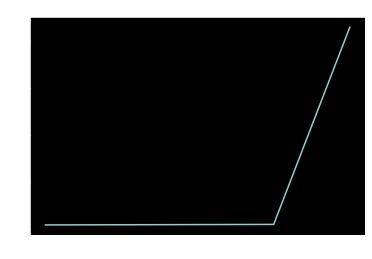

In [58]:
plt.plot(flips[-5:])

[]
1874 4 32 2048


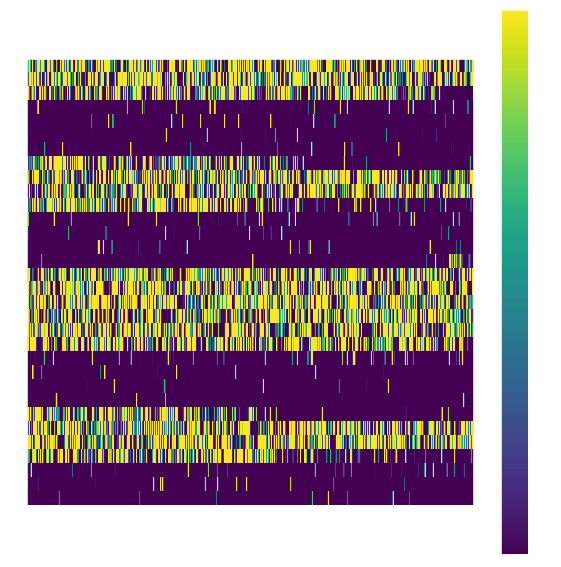

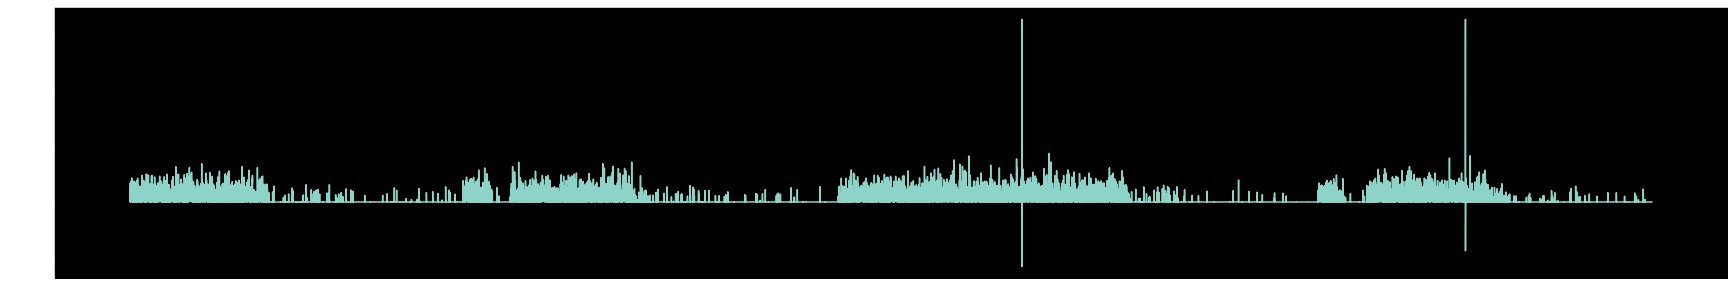

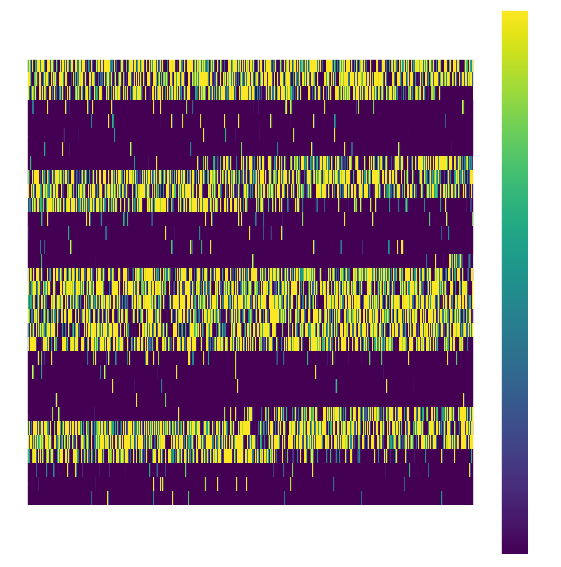

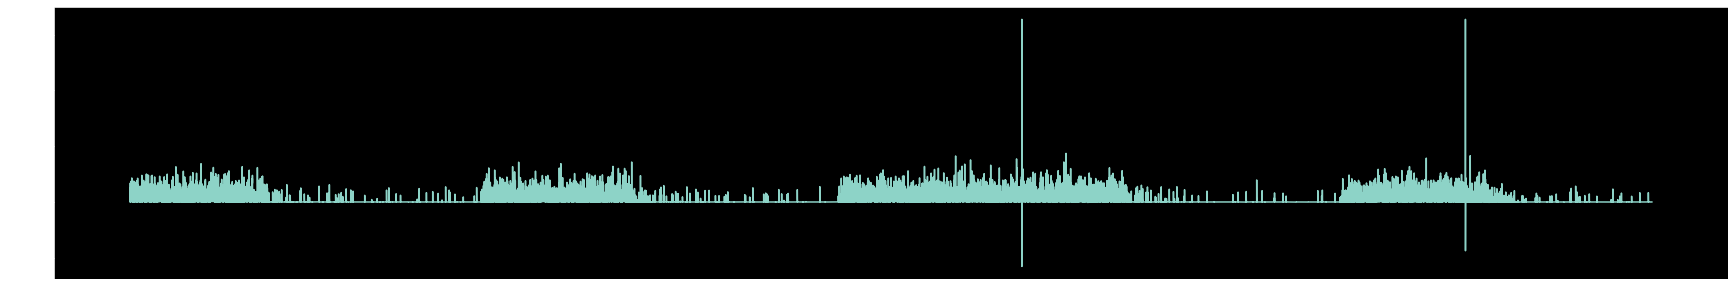

In [55]:
func = data[:,1,:,:].copy()
# func[:,1::2,:] = np.flip(func[:,1::2,:], axis=2) #bidi scanning
# func = func.flatten()

fri = 1301
# print(func.shape)

plt.figure(figsize=(10,10))
plt.imshow(func[fri],aspect=64,interpolation='none')
plt.clim(0,800)
plt.colorbar()

plt.figure(figsize=(30,5))
plt.plot(func[fri].flatten())

func[:,1::2,:] = np.flip(func[:,1::2,:], axis=2) #bidi scanning
fi = flips[np.logical_and(flips > fri*32*2048, flips < (fri+1)*32*2048)]
print(fi)

# 
plt.figure(figsize=(10,10))
plt.imshow(func[fri],aspect=64,interpolation='none')
plt.clim(0,800)
plt.colorbar()

plt.figure(figsize=(30,5))
plt.plot(func[fri].flatten())
for fii in fi:
    plt.axvline(fii - fri*32*2048, 0,1, color='w')

print(F,C,Y,X)

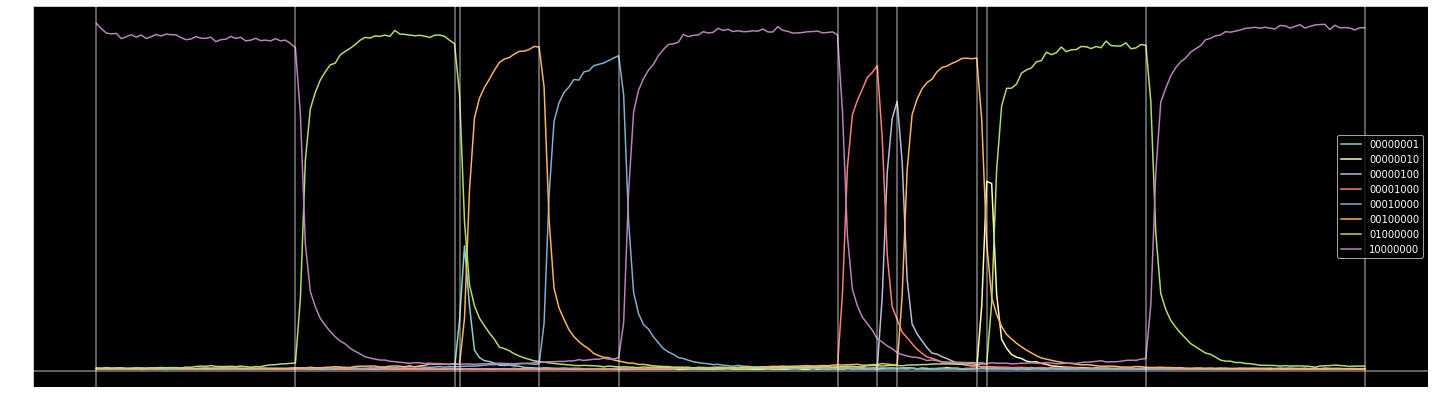

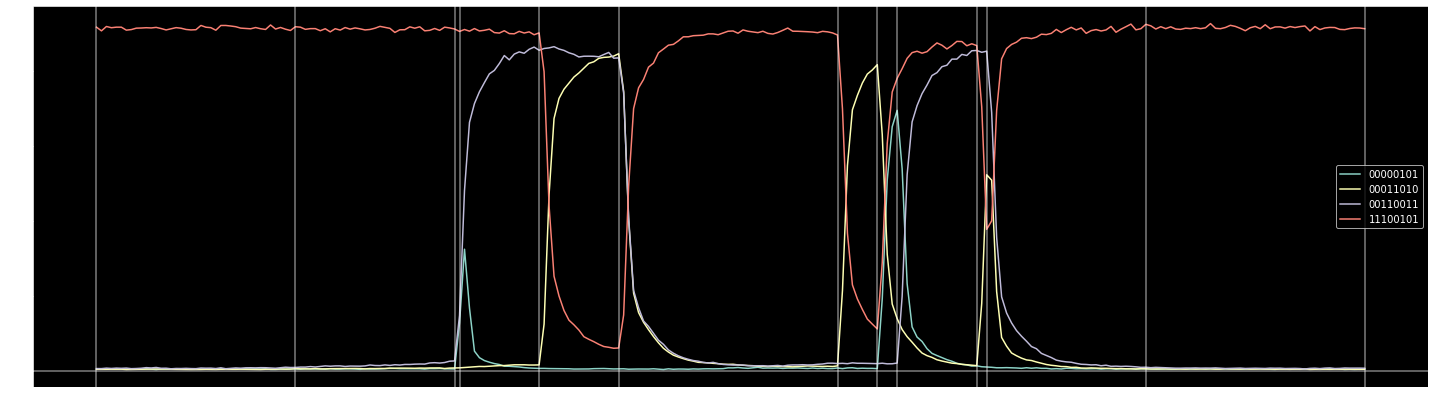

In [102]:
divs = np.asarray([42,32,1,16,16,44,8,4,16,2,32,44]).cumsum()-2 #the duration of each division
divs = np.concatenate(([0],divs))
ids = np.asarray([128,64,1,32,16,128,8,4,32,2,64,128]) # the mapping of each division onto the intensity values

if 128 in xss.keys():
    halfmax = (np.percentile(np.nanmean(xss[128], axis=0),80) - np.percentile(np.nanmean(xss[128], axis=0),5))/2
else:
    halfmax = None

# plot the individual bit patterns
plt.figure(figsize=(25,7))
for k in [1,2,4,8,16,32,64,128]:
    if k not in xss.keys(): continue
    # plt.fill_between(
    #     np.arange(256),
    #     np.nanmean(xss[k], axis=0) + np.nanstd(xss[k], axis=0)/np.sqrt(np.count_nonzero(~np.isnan(xss[k]), axis=0))*3,
    #     np.nanmean(xss[k], axis=0) - np.nanstd(xss[k], axis=0)/np.sqrt(np.count_nonzero(~np.isnan(xss[k]), axis=0))*3,
    #     alpha = .25,
    #     # label = f"{k:08b}",
    #     )
    # plt.plot(np.nanmean(xss[k], axis=0), label = f"{k:08b}")
    plt.plot(xss[k], label = f"{k:08b}")
    # x0 = np.percentile(xss[k],2)
    # xf = np.percentile(xss[k],100)
    # plt.plot((xss[k] - x0)/(xf-x0), label = f"{k:08b}")


plt.legend()
xl = plt.xlim()
yl = plt.ylim()
plt.vlines(divs,yl[0],yl[1],'w', alpha=0.5)
if halfmax is not None:
    plt.axhline(halfmax,yl[0],yl[1],color='w',alpha=0.5)
plt.xlim(xl)
plt.ylim(yl)

# plot the overlapping bit patterns that were sampled
plt.figure(figsize=(25,7))
for k in [5,26,51,229]:
    if k not in xss.keys(): continue
    # plt.fill_between(
    #     np.arange(256),
    #     np.nanmean(xss[k], axis=0) + np.nanstd(xss[k], axis=0)/np.sqrt(np.count_nonzero(~np.isnan(xss[k]), axis=0))*3,
    #     np.nanmean(xss[k], axis=0) - np.nanstd(xss[k], axis=0)/np.sqrt(np.count_nonzero(~np.isnan(xss[k]), axis=0))*3,
    #     alpha = .25,
    #     # label = f"{k:08b}",
    #     )
    # plt.plot(np.nanmean(xss[k], axis=0), label = f"{k:08b}")
    plt.plot(xss[k], label = f"{k:08b}")
    
plt.legend()
xl = plt.xlim()
yl = plt.ylim()
plt.vlines(divs,yl[0],yl[1],'w', alpha=0.5)
if halfmax is not None:
    plt.axhline(halfmax,yl[0],yl[1],color='w',alpha=0.5)
plt.xlim(xl)
plt.ylim(yl)
plt.show()

In [116]:
print(np.asarray([0,40,32,1,16,16,44,8,4,16,2,32,44]).cumsum())
# print(ids.shape)

[  0  40  72  73  89 105 149 157 161 177 179 211 255]


In [128]:
np.stack([xss[2**i] for i in range(8)]).T.shape

(256, 8)

In [89]:
divs = np.asarray([0,40,32,1,16,16,44,8,4,16,2,32,44]).cumsum() # duration of each division
ids = np.asarray([128,64,1,32,16,128,8,4,32,2,64,128]) # the mapping of each division onto the intensity values


from scipy.optimize import curve_fit
x = np.arange(256)


def rc(t, tau, vi, vf):
    dv = vf-vi

    v = np.zeros((256,8))
    for i in range(8):
        for j in range(len(ids)):
            if ids[j] == 2**i:
                if divs[j]==0: # no rise time for the beginning of the frame
                    v[0:divs[j+1]+1,i] = dv 
                else:
                    v[divs[j]:(divs[j+1]+1), i] += (dv - v[divs[j],i]) * (1-np.exp(-np.arange(divs[j+1]-divs[j]+1)/tau))

                if divs[j+1] == 255 : #no fall time for the end of the frame
                    v[-1, i] = v[-2, i]
                else:
                    v[(divs[j+1]+1):, i] = v[divs[j+1],i]* np.exp(-np.arange(255-divs[j+1])/tau)

        # v[89:105,i] = dv * (1-np.exp(-np.arange(105-89)/tau))
        # v[105:,i] = v[104] * np.exp(-np.arange(256-105)/tau)
    
    return (v + vi).T.flatten()

(tau, vi, vf), *_ = curve_fit(rc, x, np.concatenate([xss[2**i] for i in range(8)]), [1.0,1.0,1.0])

# plt.figure(figsize=(20,7))

# plt.plot(xss[16])
# plt.plot(rc(x,tau, vi, vf))


# plt.twinx()
# l = np.zeros(256)
# l[89:105] = 1

# plt.plot(l, 'w')

# # V = Vmax * (1-e^(-t/(RC)))
# # ids.shape
# # i = np.nonzero(ids==16)[0].flatten()
# # divs[i], divs[i+1]

# print(tau, vi, vf)



In [245]:
print(divs, ids)

print(tau, vi, vf)


[  0  40  72  73  89 105 149 157 161 177 179 211 255] [128  64   1  32  16 128   8   4  32   2  64 128]
2.066631039568971 7.019531913700431 838.8059846283934


In [103]:
plt.figure(figsize=(25,7))
plt.plot(np.stack([xss[2**i] for i in range(8)]).T)

plt.plot(rc(x,tau,vi,vf).reshape(8,256).T, 'w')


# plt.plot(rc(x,tau,vi,vf).reshape(8,256).T - np.stack([xss[2**i] for i in range(8)])

plt.twinx()
plt.plot(rc(x,tau,vi,vf).reshape(8,256).T > (vi+.03))


NameError: name 'xss' is not defined

<Figure size 1800x504 with 0 Axes>

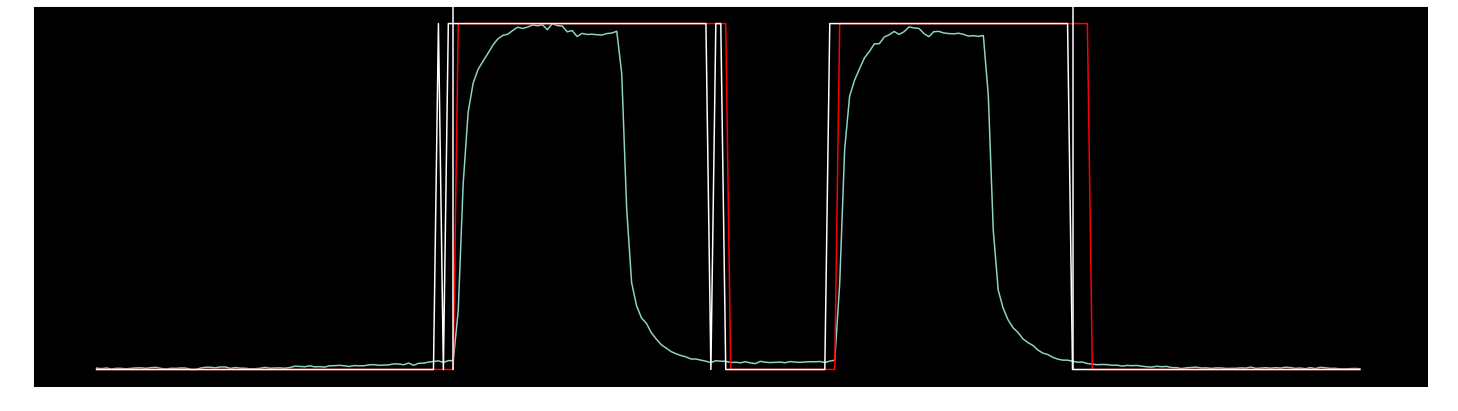

In [250]:
x2 = np.zeros_like(xss[1])
for k in [1,2,4,8,16,32]:
    x2 += xss[k]

x2 -= x2[:64].mean()
x2 /= x2[:64].std()

plt.figure(figsize=(25,7))
plt.plot(x2)

plt.twinx()
plt.plot(np.any(rc(x,tau,vi,vf).reshape(8,256).T[:,:6] > (vi+.03), axis=1), 'r')
plt.plot(x2 > 4,'w')

yl = plt.ylim()
plt.ylim(yl[0], -yl[0]+1)

plt.hlines(3, 0,256)
plt.vlines([72, 197], x2[:64].mean(), x2.max())



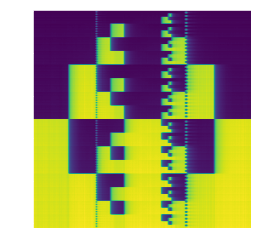

In [116]:
# mod = rc(x,tau,vi,vf).reshape(8,256).T
trace = np.zeros((256,256))

for i in range(256):
    for j in range(8):
        if i & 2**j:
            # trace[i,:] += mod[:,j]
            trace[i,:] += xss[2**j]
    # res[i,:] |= 


plt.imshow(trace)
np.save('artifact_trace.npy', trace)

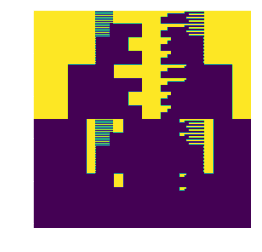

In [265]:
mod = rc(x,tau,vi,vf).reshape(8,256).T > (vi+.03)
res = np.zeros((256,256), dtype=bool)

for i in range(256):
    for j in range(8):
        if i & 2**j:
            res[i,:] |= mod[:,j]
    # res[i,:] |= 


res = ~res
# plt.plot(rc(x,tau,vi,vf).reshape(8,256).T > vi+0.05)

plt.imshow(res)
np.save('artifact_lut.npy', res)

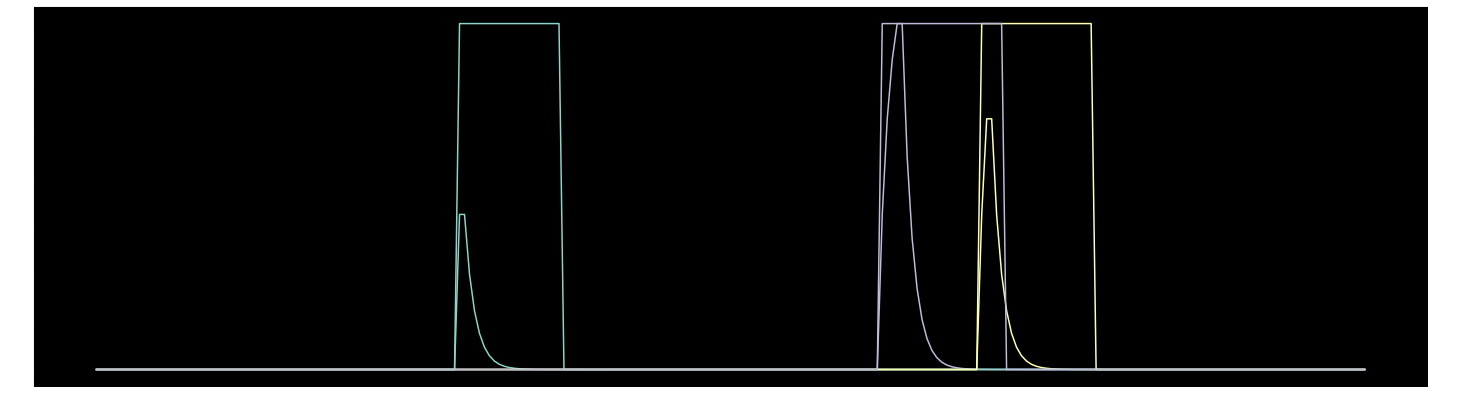

In [263]:
plt.figure(figsize=(25,7))

plt.plot((rc(x,tau,vi,vf).reshape(8,256).T)[:,:3])
plt.twinx()
plt.plot(res[1,:])
plt.plot(res[2,:])
plt.plot(res[4,:])

In [2]:
fname = "C:\\Users\\zfj\\data\\033023B_bleed_testing\\chirp_00002.tif"

data, props = preprocess.read_raw_file(fname, None)
_, flips = preprocess.get_trigger_times(data, props)

# # the flips are calculated after undoing the bidi scanning
flips = np.sort(flips) #not necessary?
# flip_i = (flips // 128) % 2 == 1 #if the line number is odd, this is a retraced line
# # recalculate the flips by redoing the bidi scanning
# flips[flip_i] = (flips[flip_i] // 128) * 128 + (128 - (flips[flip_i] % 128)) 


#get the approximate time of each pixel
F,C,Y,X = data.shape
tt = np.zeros((F,Y,X))
tt += np.arange(0, X)[None, None, :] / props['pixel_rate']
# tt[:,1::2,:] = np.flip(tt[:,1::2,:], axis=2) #bidi scanning
tt += np.arange(0, Y)[None, :, None] / props['line_rate']
tt += ((props['time_stamps'] - props['time_stamps'][0]) / 1e7)[:, None, None]
tt = tt.flatten()


In [3]:
trig = data[:,-1,:,:].copy()
trig[:,1::2,:] = np.flip(trig[:,1::2,:], axis=2)
trig = trig.flatten()

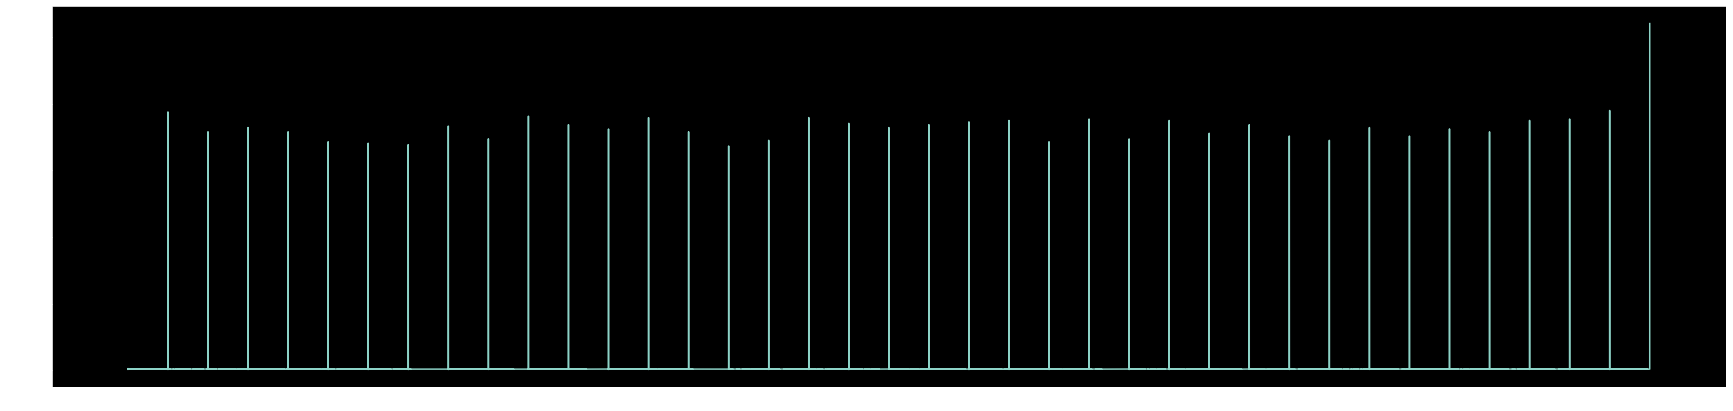

In [4]:
plt.figure(figsize=(30,7))
plt.plot(np.diff(flips))
# plt.ylim(0,5000)
# plt.xlim(10040,10050)

24792280 88 25


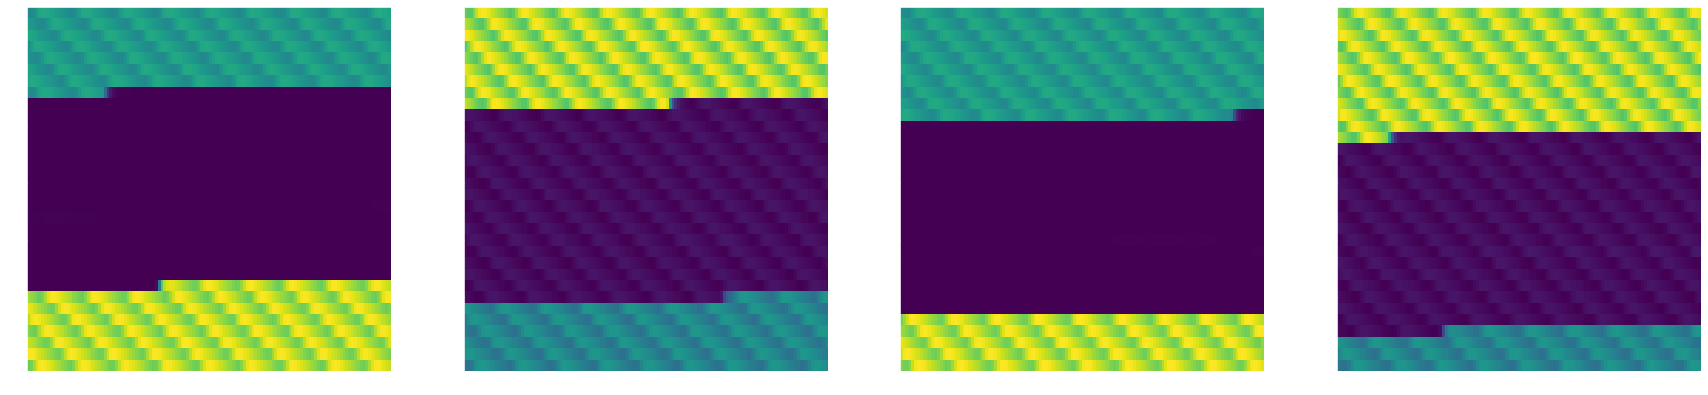

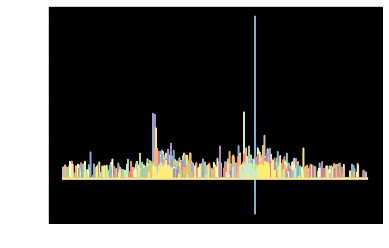

In [5]:
fi = 10044
print(flips[fi], flips[fi]%128, (flips[fi]//128) % 32)

_,axs = plt.subplots(1,4,figsize=(30,7))
axs[0].imshow(trig.reshape((-1,32,128))[flips[fi] // (32*128) - 1], aspect=4, interpolation='none')
axs[1].imshow(trig.reshape((-1,32,128))[flips[fi] // (32*128) - 0], aspect=4, interpolation='none')
axs[2].imshow(trig.reshape((-1,32,128))[flips[fi] // (32*128) + 1], aspect=4, interpolation='none')
axs[3].imshow(trig.reshape((-1,32,128))[flips[fi] // (32*128) + 2], aspect=4, interpolation='none')

# plt.imshow(data[:,0][flips[fi] // (32*128)], aspect=4, interpolation='none')
plt.show()


anat = data[:,0].copy()
anat[:,1::2,:] = np.flip(anat[:,1::2,:], axis=2)
anat = anat.flatten()

for fi in range(fi, fi+50):
    plt.plot(anat[flips[fi]:flips[fi+1]])





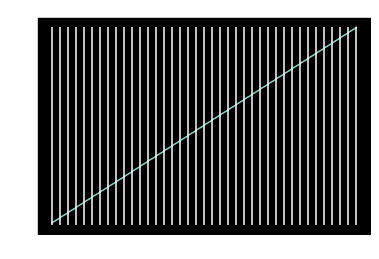

38
[1945815 1948487 1950409 ... 6411638 6413819 6415892]
[2100, 2100, 2100, 2101, 2100, 2100, 2100, 2101, 2101, 2100, 2100, 2100, 2100, 2100, 2100, 2100, 2100, 2100, 2101, 2099, 2100, 2100, 2100, 2100, 2100, 2100, 2100, 2100, 2100, 2100, 2100, 2100, 2100, 2100, 2100, 2100, 2100, 2101]
2099


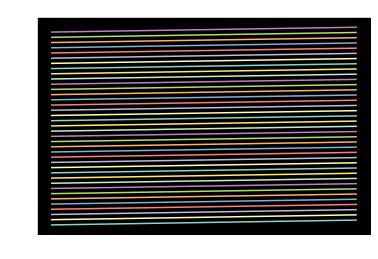

In [6]:
# func = data[:,1,:,:].copy()
# # func[:,1::2,:] = np.flip(func[:,1::2,:], axis=2) #bidi scanning
# # func = func.flatten()

# fri = 1301
# # print(func.shape)

# plt.figure(figsize=(10,10))
# plt.imshow(func[fri],aspect=4,interpolation='none')
# plt.clim(0,800)
# plt.colorbar()

# plt.plot(trig[:10000000:1000])

# plt.plot(flips[(32*60):(70*60)])

class intervals:
    def __init__(self, array):
        self.i = 0
        self.N = len(array)
        self.array = array
    def __iter__(self):
        return self
    def __next__(self):
        self.i += 1
        if self.i < self.N:
            # print(self.array[self.i-1], self.array[self.i])
            return self.array[self.i-1], self.array[self.i]
        raise StopIteration

trial_i = np.nonzero(np.diff(flips, prepend=0) > 1e5)[0]
# trial_i = np.insert(trial_i, 0, 0)

plt.plot(flips)
plt.vlines(trial_i, 0, flips[-1])
# print(trial_i)
plt.show()

trials = [flips[i:j] for i,j in intervals(trial_i)]
print(len(trials))
print(trials[0])

# plt.plot(trials[0])
# plt.plot(trials[1])
[plt.plot(trial) for trial in trials]
print([len(trial) for trial in trials])

tmin = min([len(trial) for trial in trials])
print(tmin)


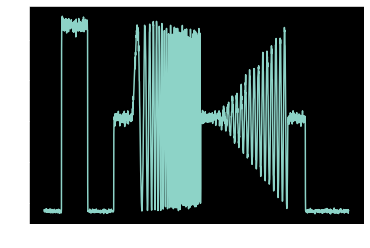

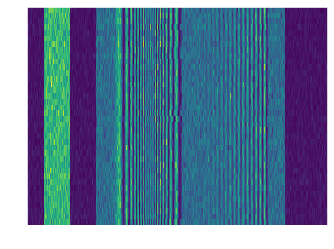

475


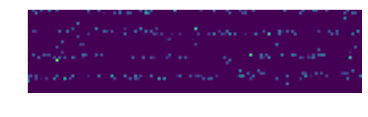

In [91]:
anat = data[:,0,:,:].copy()
anat[:,1::2,:] = np.flip(anat[:,1::2,:], axis=2) #bidi scanning
anat = anat.flatten()

# fmed = np.mean(func, axis=(1,2))
# print(np.argmax(fmed))
# print(fmed)
# plt.imshow(func[39473], aspect=4, interpolation='none')
mv = np.zeros((len(trials), tmin - 1))
for j,trial in enumerate(trials):
    for i in range(tmin - 1):
        mv[j,i] += np.mean(anat[trial[i] : trial[i+1]])

# plt.plot(np.linspace(0,35,len(mv)),mv)
# plt.plot(np.linspace(0,35,tmin - 1),mv.mean(axis=0))
plt.plot(mv.mean(axis=0))
plt.show()

plt.imshow(mv, aspect=40, interpolation='none')
plt.show()

print(trials[0][0] // (32*128))
plt.imshow(data[trials[1][0] // (32*128) + 96,0,:,:])

In [8]:
# from numba import jit

# @jit
def get_bleed(func, tt, flips, props, func_chan = 1):

  #get the approximate time of each pixel
  # F,C,Y,X = data.shape
  # tt = np.zeros((F,Y,X))
  # tt += np.arange(0, X)[None, None, :] / props['pixel_rate']
  # # tt[:,1::2,:] = np.flip(tt[:,1::2,:], axis=2) #bidi scanning
  # tt += np.arange(0, Y)[None, :, None] / props['line_rate']
  # tt += ((props['time_stamps'] - props['time_stamps'][0]) / 1e7)[:, None, None]
  # tt = tt.flatten()

  # func = data[:,func_chan,:,:].copy()
  # func[:,1::2,:] = np.flip(func[:,1::2,:], axis=2) #bidi scanning
  # func = func.flatten()
  #NOTE: we're flipping the data channel so that the time is strictly increasing

  xs = np.zeros(256)#, dtype=np.int64)
  xn = np.zeros(256)#, dtype=np.int64)

  for i in range(len(flips)- 1):
    if not flips[i] % props['frame_shape'][1]:
      continue

    inds = ((tt[flips[i] : flips[i+1]] - tt[flips[i]]) / (tt[flips[i+1]] - tt[flips[i]]) * 256).astype(int)
    #NOTE: we multiply by 256 because conversion to int rounds down
    #TODO: this is very slow
    for ind,f in zip(inds, func[flips[i] : flips[i+1]]):
      xs[ind] += f
      xn[ind] += 1
  
  # print('')
  return xs/xn


F,C,Y,X = data.shape
tt = np.zeros((F,Y,X))
tt += np.arange(0, X)[None, None, :] / props['pixel_rate']
# tt[:,1::2,:] = np.flip(tt[:,1::2,:], axis=2) #bidi scanning
tt += np.arange(0, Y)[None, :, None] / props['line_rate']
tt += ((props['time_stamps'] - props['time_stamps'][0]) / 1e7)[:, None, None]
tt = tt.flatten()

anat = data[:,0,:,:].copy()
print(anat.shape)
anat[:,1::2,:] = np.flip(anat[:,1::2,:], axis=2) #bidi scanning
anat = anat.flatten()

bleed = np.empty((len(trials), 256))
null = np.empty_like(bleed)
for i,trial in enumerate(trials):
  # print(len(trial[120:300]), trial[120],trial[121])
  # bleed[i,:] = get_bleed(data, trial[96:160], props, func_chan=0)
  bleed[i,:] = get_bleed(anat, tt, trial[120:300], props, func_chan=0)
  null[i,:] = get_bleed(anat, tt, trial[1820:2000], props, func_chan=0)

(45344, 32, 128)


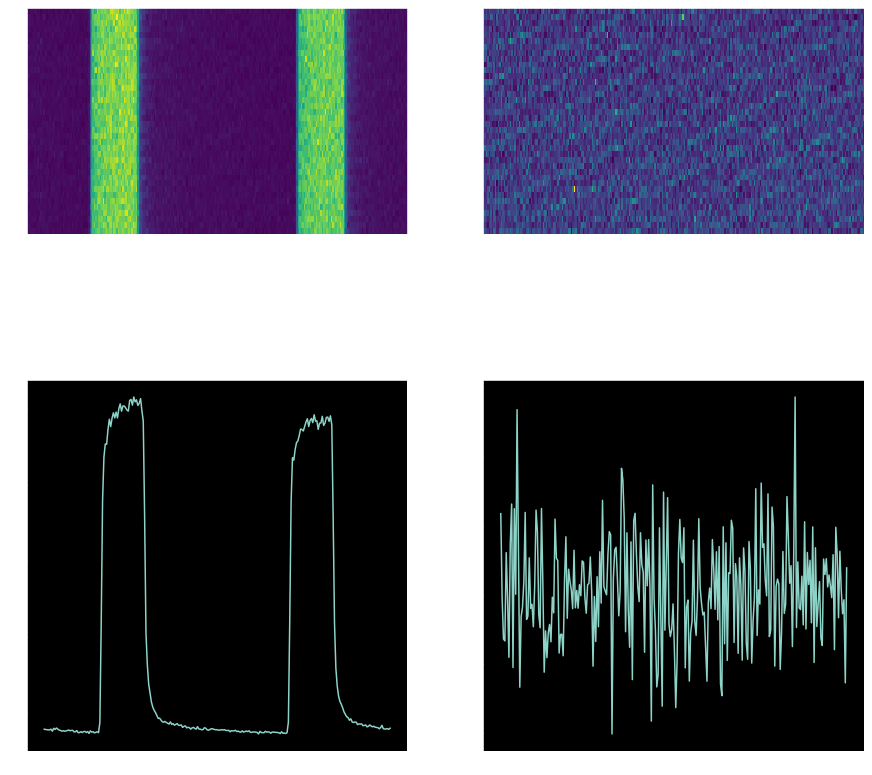

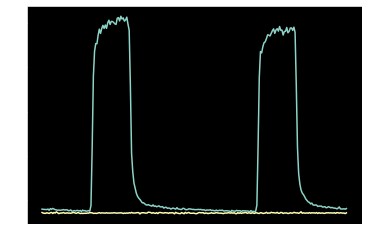

In [9]:
_,axs = plt.subplots(2,2,figsize=(15,15))
axs = axs.flatten()
axs[0].imshow(bleed, aspect=4, interpolation='none')
axs[2].plot(bleed.mean(axis=0))


axs[1].imshow(null, aspect=4, interpolation='none')
axs[3].plot(null.mean(axis=0))
# plt.plot(bleed[0])
plt.show()
plt.plot(bleed.mean(axis=0))
plt.plot(null.mean(axis=0))



In [303]:
def chirp_pattern(intensity, sf = 60):
   sf = int(sf)
   chirp = np.concatenate((
        np.zeros(2*sf), #pre time
        np.ones(3*sf), #positive step
        np.zeros(3*sf), #negative time
        np.ones(2*sf) * 0.5, #inter time
        
        -np.sin(2*np.pi*np.linspace(0,8/sf,sf*8).cumsum() + np.pi)/2 + .5, # freq chirp

        np.ones(2*sf) * 0.5, #inter time
        -np.linspace(0,1,sf*8)*np.sin(2*np.pi*2*np.arange(1/sf, 8+(1/sf), 1/sf) + np.pi)/2 + .5, # amp chirp
      

        np.ones(2*sf) * 0.5, #inter time
        np.zeros(5*sf), #tail time
   )) 

   return np.round(chirp * 255 * intensity).astype(np.uint8)#.astype(float) / (255 * intensity)
#    return (chirp * 255 * intensity).astype(np.uint8)#.astype(float) / (255 * intensity)

(array([ 38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233],
      dtype=int64),)


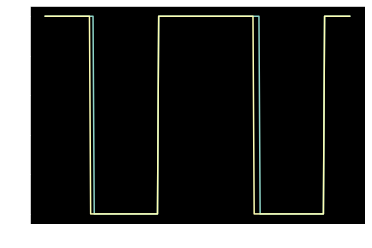

In [304]:
# pattern[121]
lookup = np.load('artifact_lut.npy')

255 * .25
plt.plot(lookup[64])
plookup = lookup[64].copy()
plookup[38:50] = False
plookup[175:200] = False
plt.plot(plookup)
# pattern[121]

print(np.nonzero(~plookup))

In [305]:
mask = np.zeros_like(anat, dtype=bool)
lookup = np.load('artifact_lut.npy')

# lookup[64][38:120] = False
# lookup[64][175:250] = False


#for now, we know the intensity is 0.125 == 1/8 aka 32 aka 00100000
pattern = chirp_pattern(0.25, 60.0)
# pattern = chirp_pattern(0.25, 60.0)


for i,trial in enumerate(trials):
    
    for i,(a,b) in enumerate(intervals(trial[:2100])):
        ta,tb = tt[a],tt[b]

        frame_mask = lookup[pattern[i]]
        # frame_subind = (np.arange(tb-ta)/(tb-ta)*256).astype(np.uint8) #now these range from 0 to 255
        inds = ((tt[a : b] - ta) / (tb - ta) * 256).astype(int)
        mask[a:b] = frame_mask[inds]

        # inds = ((tt[flips[i] : flips[i+1]] - tt[flips[i]]) / (tt[flips[i+1]] - tt[flips[i]]) * 256).astype(int)
        # #NOTE: we multiply by 256 because conversion to int rounds down
        # #TODO: this is very slow
        # for ind,f in zip(inds, func[flips[i] : flips[i+1]]):
        #   xs[ind] += f
        #   xn[ind] += 1


#at the end, we need to make sure to flip the mask so that it looks like the image...

64


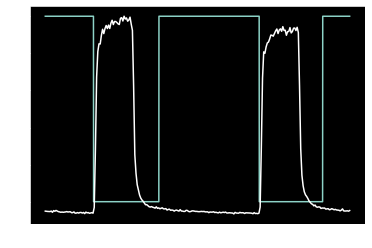

In [306]:
fi = 120

plt.plot(np.linspace(0,255, trials[0][fi+1] - trials[0][fi]),mask[trials[0][fi]:trials[0][fi+1]])
# plt.twiny()

print(pattern[fi])

plt.plot(bleed.mean(axis=0) / bleed.mean(axis=0).max(), 'w')

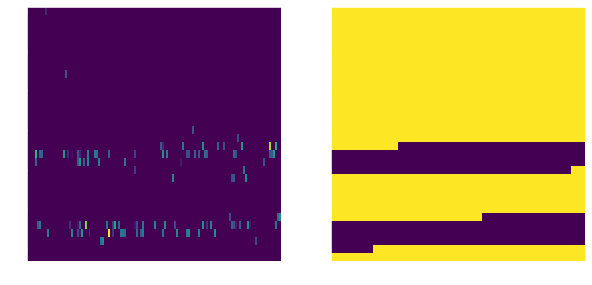

In [307]:
# mask = mask.reshape((-1,32,128))
# # mask[:,1::2,:] = np.flip(mask[:,1::2,:], axis=2)
# mask = mask.flatten()

fi = 120
_,axs = plt.subplots(1,2,figsize=(10,5))

axs[0].imshow(anat.reshape((-1,32,128))[trials[0][fi]//(32*128)], aspect=4, interpolation='none')
axs[1].imshow(mask.reshape((-1,32,128))[trials[0][fi]//(32*128)], aspect=4, interpolation='none')

# plt.plot(lookup[pattern[150]])
# a,b = trials[0][150] , trials[0][151]
# ta,tb = tt[a],tt[b]
# inds = ((tt[a : b] - ta) / (tb - ta) * 256).astype(int)
# plt.plot(inds)

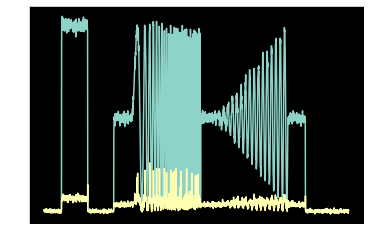

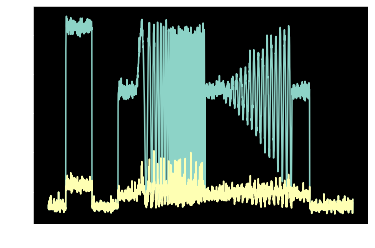

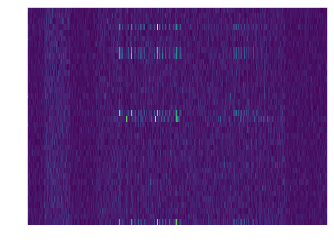

3

In [308]:
# anat = data[:,0,:,:].copy()
# anat[:,1::2,:] = np.flip(anat[:,1::2,:], axis=2) #bidi scanning
# anat = anat.flatten()

nmask = mask.astype(float)
nmask[nmask==0] = np.nan

# # fmed = np.mean(func, axis=(1,2))
# print(np.argmax(fmed))
# print(fmed)
# plt.imshow(func[39473], aspect=4, interpolation='none')

mv = np.zeros((len(trials), tmin - 1))
ms = mv.copy()
mmv = mv.copy()
mms = mv.copy()
for j,trial in enumerate(trials):
    for i in range(tmin - 1):
        mv[j,i] += np.mean(anat[trial[i] : trial[i+1]])
        mmv[j,i] += np.nanmean(anat[trial[i] : trial[i+1]] * nmask[trial[i] : trial[i+1]])

        
        ms[j,i] += np.std(anat[trial[i] : trial[i+1]])
        mms[j,i] += np.nanstd(anat[trial[i] : trial[i+1]] * nmask[trial[i] : trial[i+1]])

# plt.plot(np.linspace(0,35,len(mv)),mv)
# plt.plot(np.linspace(0,35,tmin - 1),mv.mean(axis=0))
plt.plot(mv.mean(axis=0))
plt.plot(mmv.mean(axis=0))
plt.show()

plt.plot(ms.mean(axis=0))
plt.plot(mms.mean(axis=0))
plt.show()

plt.imshow(mmv, aspect=40, interpolation='none')
plt.show()

# print(trials[0][0] // (32*128))
# plt.imshow(data[trials[1][0] // (32*128) + 96,0,:,:])

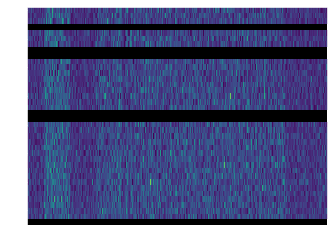

In [363]:
mmvc = mmv.copy()
for i in [3,7,8,18,19,37]:
    mmvc[i,:] = np.nan

plt.imshow(mmvc, aspect=40, interpolation='none')

In [309]:
#...

mbleed = np.empty((len(trials), 256))
# null = np.empty_like(bleed)
for i,trial in enumerate(trials):
  # print(len(trial[120:300]), trial[120],trial[121])
  # bleed[i,:] = get_bleed(data, trial[96:160], props, func_chan=0)
  mbleed[i,:] = get_bleed(anat * nmask, tt, trial[120:300], props, func_chan=0)
#   null[i,:] = get_bleed(anat, tt, trial[1820:2000], props, func_chan=0)

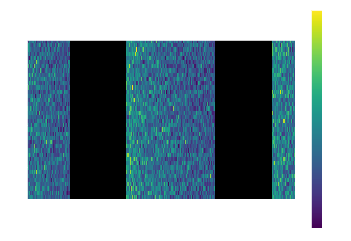

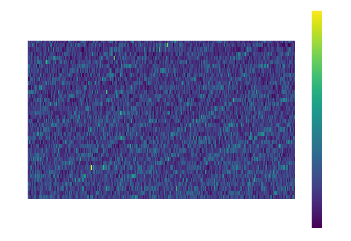

In [310]:
plt.imshow(mbleed, aspect=4, interpolation='none')
plt.clim(-8,2)
plt.colorbar()
plt.show()

plt.imshow(null, aspect=4, interpolation='none')
plt.clim(-8,2)
plt.colorbar()
plt.show()

In [311]:
def get_each_bleed(func, tt, flips, props, func_chan = 1):
  xs = np.zeros((len(flips)-1, 256))#, dtype=np.int64)
  xn = np.zeros((len(flips)-1, 256))#, dtype=np.int64)

  for i in range(len(flips)- 1):
    if (not (flips[i] - 1) % props['frame_shape'][1]) or (not (flips[i+1] - 1) % props['frame_shape'][1]):
      xs[i,:] = np.nan
      xn[i,:] = np.nan
      continue

    inds = ((tt[flips[i] : flips[i+1]] - tt[flips[i]]) / (tt[flips[i+1]] - tt[flips[i]]) * 256).astype(int)
    #NOTE: we multiply by 256 because conversion to int rounds down
    #TODO: this is very slow
    for ind,f in zip(inds, func[flips[i] : flips[i+1]]):
      xs[i, ind] += f
      xn[i, ind] += 1
  
    if xn[i,1] == 0 and xn[i,8] == 0:
      print(flips[i])
      xs[i,:] = np.nan
      xn[i,:] = np.nan
      
      xs[i-1,:] = np.nan
      xn[i-1,:] = np.nan


  # print('')
  return xs/xn

ebleed = np.empty((len(trials), 2098, 256))
enull = np.empty_like(ebleed)
emask = np.empty_like(ebleed)
for i,trial in enumerate(trials):
  ebleed[i,:,:] = get_each_bleed(anat, tt, trial[:2099], props, func_chan=0)
  # enull[i,:,:] = get_each_bleed(anat, tt, trial[1820:2001], props, func_chan=0)
  emask[i,:,:] = get_each_bleed(anat * nmask, tt, trial[:2099], props, func_chan=0)

1990650
2207741
2260989
2314237
2367482
2420730
2473978
2527226
2580476
2633725
2686973
2740218
2793466
2846714
2899962
2953213
3006461
3059706
3112954
3330045
3383293
3436538
3489786
3543034
3596283
3649533
3702781
3756026
3809274
3862522
3915770
3969019
4022269
4075517
4128762
4182010
4235258
4452349
4505594
4558842
4612090
4665339
4718589
4771837
4825082
4878330
4931578
4984826
5038075
5091325
5144573
5197818
5251066
5304314
5357562
5574651
5627898
5681146
5734396
5787645
5840893
5894138
5947386
6000634
6053882
6107132
6160381
6213629
6266874
6320122
6373370


C:\Users\zfj\AppData\Local\Temp\ipykernel_27856\406784664.py:28: RuntimeWarning: invalid value encountered in true_divide
  return xs/xn


1990650
2207741
2260989
2314237
2367482
2420730
2473978
2527226
2580476
2633725
2686973
2740218
2793466
2846714
2899962
2953213
3006461
3059706
3112954
3330045
3383293
3436538
3489786
3543034
3596283
3649533
3702781
3756026
3809274
3862522
3915770
3969019
4022269
4075517
4128762
4182010
4235258
4452349
4505594
4558842
4612090
4665339
4718589
4771837
4825082
4878330
4931578
4984826
5038075
5091325
5144573
5197818
5251066
5304314
5357562
5574651
5627898
5681146
5734396
5787645
5840893
5894138
5947386
6000634
6053882
6107132
6160381
6213629
6266874
6320122
6373370
6803452
6856698
6909946
6963196
7016445
7069693
7122938
7176186
7229434
7282682
7335932
7389181
7442429
7495674
7548922
7766013
7819258
7872506
7925754
7979002
8032252
8085501
8138749
8191994
8245242
8298490
8351739
8404988
8458237
8511485
8564730
8617978
8671224
8888314
8994810
9048058
9101309
9154557
9207802
9261050
9314298
9367546
9420795
9474045
9527293
9580538
9633786
9687034
9740282
9957372
10010618
10063866
10117114
10170

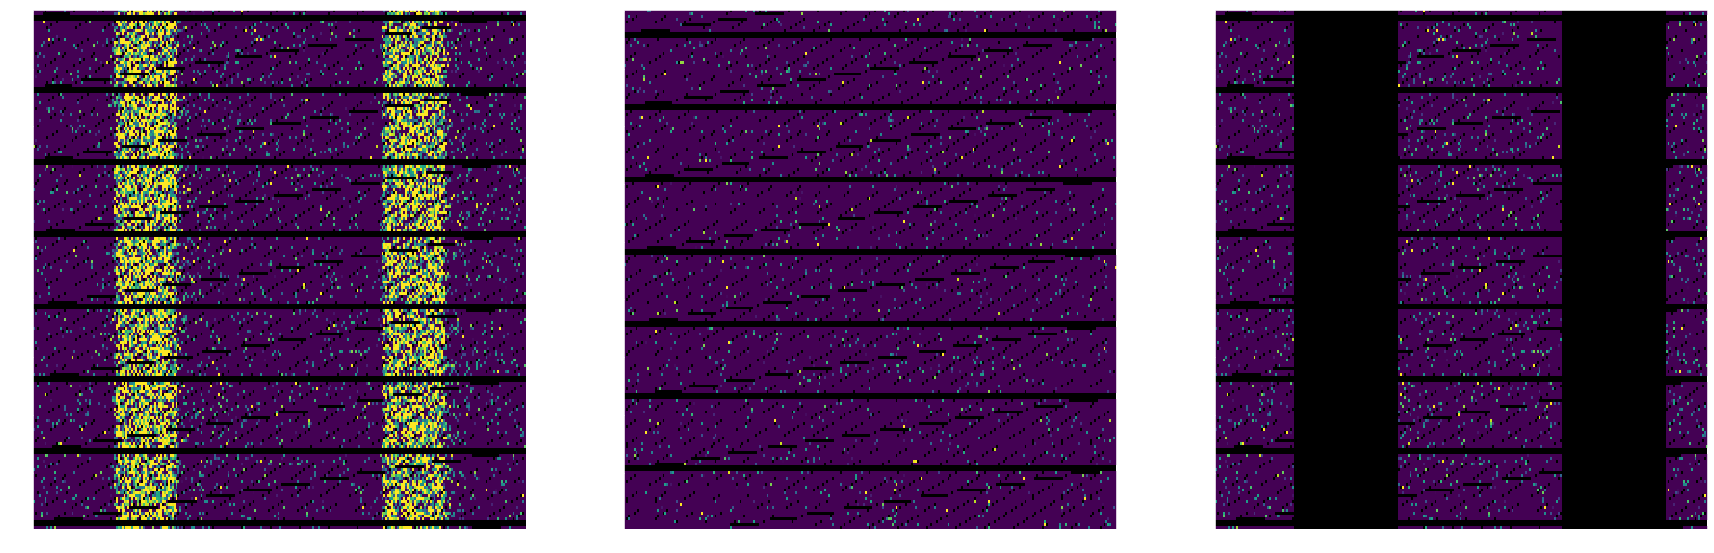

In [312]:
_,axs = plt.subplots(1,3,figsize=(30,12))

tri = 0

im = axs[0].imshow(ebleed[tri][120:300], aspect=3/2, interpolation='none')
im.set_clim(0,100)

im = axs[1].imshow(ebleed[tri][1820:2000], aspect=3/2, interpolation='none')
im.set_clim(0,100)

im = axs[2].imshow(emask[tri][120:300], aspect=3/2, interpolation='none')
im.set_clim(0,100)

# axs[0].colorbar()

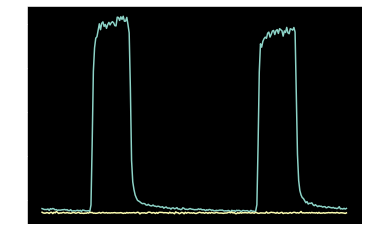

In [313]:
plt.plot(np.nanmean(ebleed[:,120:300,:], axis=(0,1)))
plt.plot(np.nanmean(ebleed[:,1820:2000,:], axis=(0,1)))


C:\Users\zfj\AppData\Local\Temp\ipykernel_27856\2077950307.py:5: RuntimeWarning: Mean of empty slice
  im = axs[1].imshow(np.nanmean(emask, axis=0), aspect=1/6, interpolation='none')


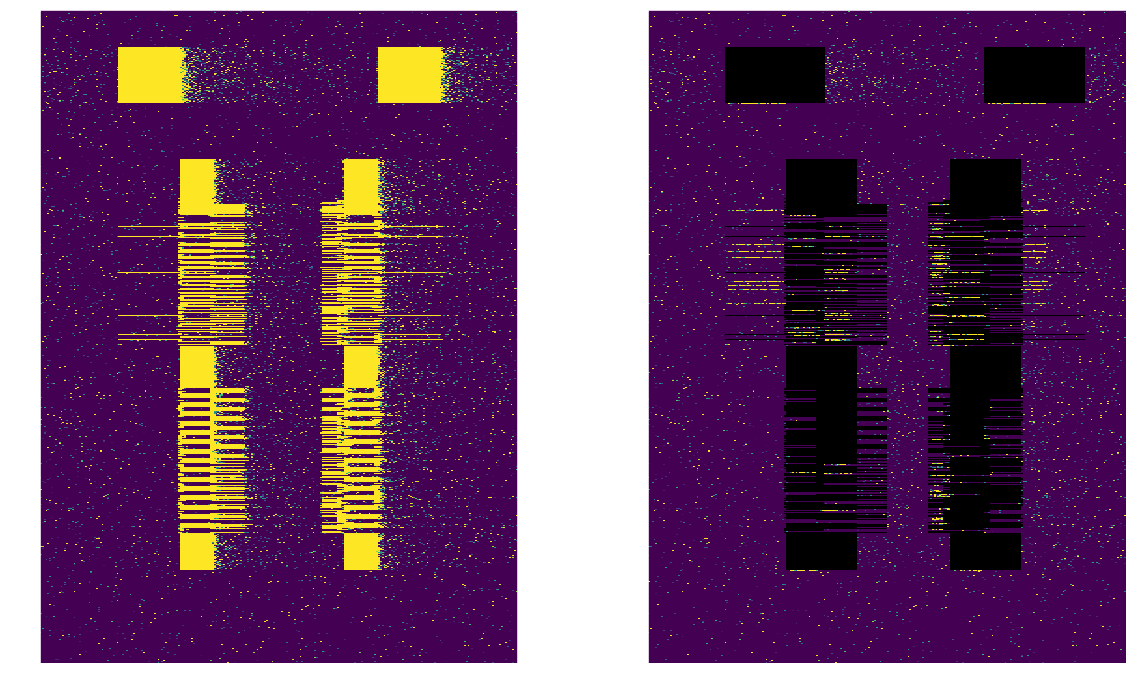

In [365]:
_,axs = plt.subplots(1,2,figsize=(20,12))
im = axs[0].imshow(np.nanmean(ebleed, axis=0), aspect=1/6, interpolation='none')
im.set_clim(0,5)

im = axs[1].imshow(np.nanmean(emask, axis=0), aspect=1/6, interpolation='none')
im.set_clim(0,5)


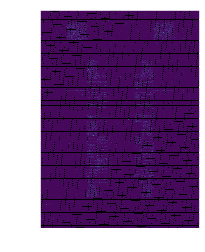

In [370]:
ebleed.shape
# plt.imshow(ebleed[2], interpolation='none', aspect=1/6)

C:\Users\zfj\AppData\Local\Temp\ipykernel_27856\741786052.py:4: RuntimeWarning: All-NaN slice encountered
  enbleed = ebleed - np.nanmin(ebleed,axis=2, keepdims=True)
C:\Users\zfj\AppData\Local\Temp\ipykernel_27856\741786052.py:5: RuntimeWarning: All-NaN slice encountered
  enbleed /= np.nanmax(enbleed, axis=2, keepdims = True)
c:\Users\zfj\anaconda3\envs\suite2p\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\zfj\anaconda3\envs\suite2p\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


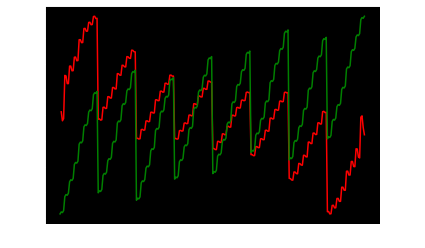

In [371]:
# plt.plot(np.nanmean(ebleed[:,1250,:], axis=0))
trace = np.load('artifact_trace.npy')

enbleed = ebleed - np.nanmin(ebleed,axis=2, keepdims=True)
enbleed /= np.nanmax(enbleed, axis=2, keepdims = True)

plt.plot([np.corrcoef(np.nanmean(ebleed[:,1250,:], axis=0), trace[i])[0,1] for i in range(256)], 'r')
plt.twinx()
plt.plot([np.dot(np.nanmean(enbleed[:,1250,:], axis=0), trace[i]) for i in range(256)], 'g')

# np.corrcoef(np.nanmean(ebleed[:,1250,:], axis=0), lookup[64])[0,1]

In [372]:
# fi = 120

for i in [3,7,8,18,19,37]:
    ebleed[i] = np.nan


c = np.empty((2098))
d = np.empty((2098))
for fi in range(2098):

    c[fi] = np.nanargmax([np.corrcoef(np.nanmean(ebleed[:,fi,:], axis=0), trace[i])[0,1] for i in range(256)])
    d[fi] = np.nanargmax([np.dot(np.nanmean(enbleed[:,fi,:], axis=0), trace[i]) for i in range(256)])

# plt.plot(np.nanmean(ebleed[:,fi,:],axis=0), 'g')
# plt.twinx()
# plt.plot(trace[np.nanargmax(c)])

# np.argmax(c)
c[pattern[:len(c)] == 0] = 0
# plt.plot(c,'r')
# plt.twinx()
# plt.plot(d,'g')

523

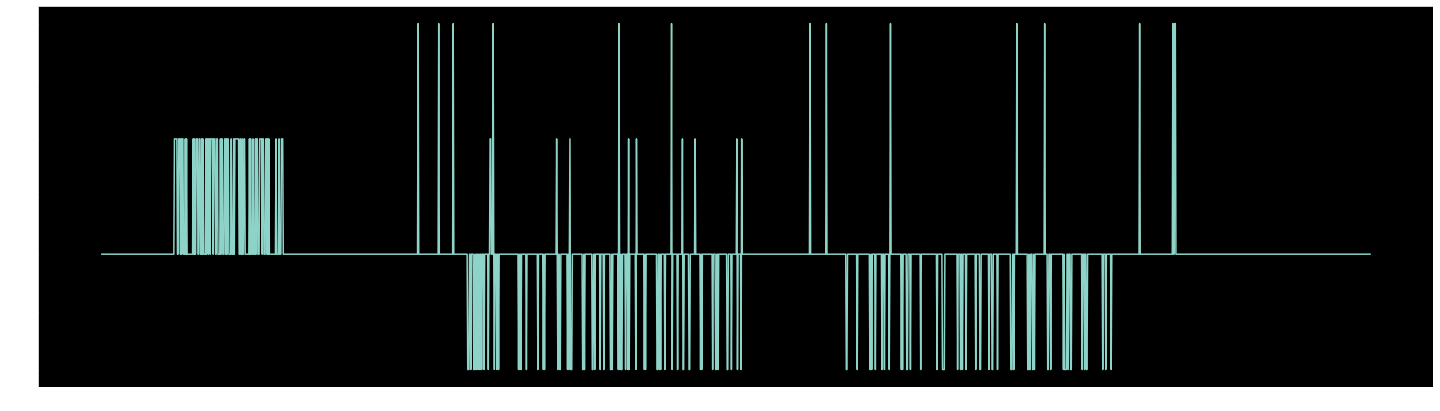

In [374]:
# p = np.concatenate((pattern[:1200], pattern[1201:]))

# c[pattern[:len(c)] == 0] = 0
plt.figure(figsize=(25,7))

plt.plot(c - pattern[:2098])

(c - pattern[:2098]).argmax()
# plt.plot(c - p[:2098])
# plt.plot(c)
# plt.twinx()
# plt.plot(pattern)
# plt.plot(d)

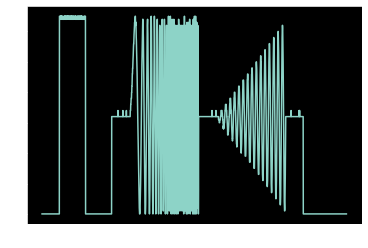

In [375]:
plt.plot(c)

(2100,) (2098,) (256, 256) (2098, 256) (38, 2098, 256)


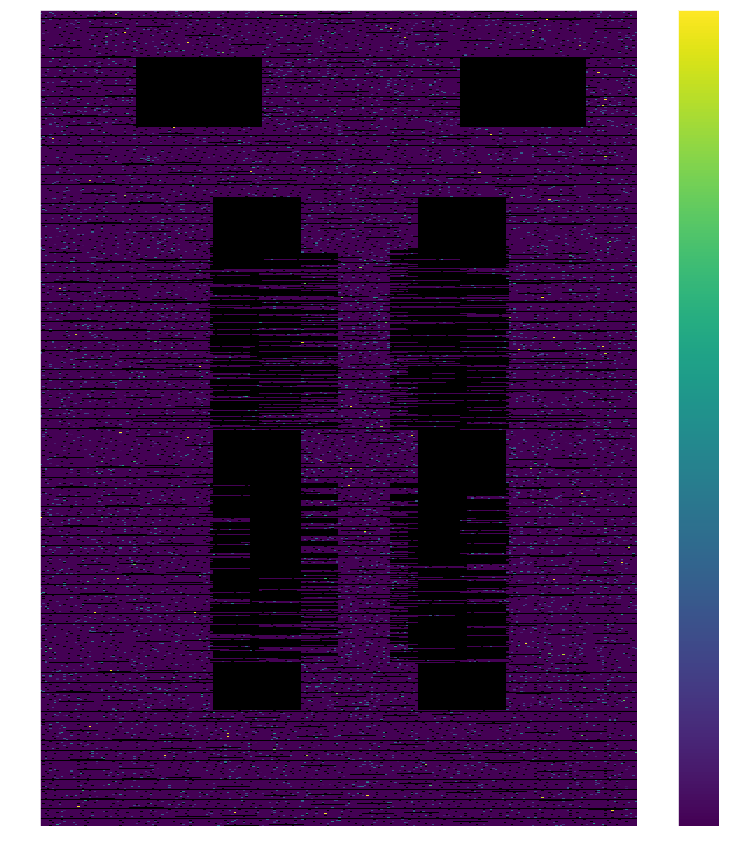

In [390]:
#so take lut[c.astype(int)] and use that as mask
print(pattern.shape, c.shape, lookup.shape, lookup[c.astype(int)].shape, ebleed.shape)

# nmask = (lookup[c.astype(int)]).astype(float)
# nmask[nmask==0] = np.nan

nmask = (lookup[pattern[:2098]]).astype(float)
nmask[nmask==0] = np.nan

# nmask = np.ones((2098,256))
# nmask[:,40:128] = np.nan
# nmask[:,150:240] = np.nan

# print(nmask.dtype)

plt.figure(figsize=(15,15))
plt.imshow(ebleed[0] * nmask, aspect=1/6, interpolation='none')
# plt.imshow(ebleed[0], aspect=1/6, interpolation='none')
# plt.imshow(nmask, aspect=1/6, interpolation='none')

plt.colorbar()
plt.clim(0,200)

In [388]:
# nmask = (lookup[c.astype(int)]).astype(float)
# nmask[nmask==0] = np.nan
nmask = np.ones((2098,256))
nmask[:,40:128] = 0
nmask[:,150:240] = 0

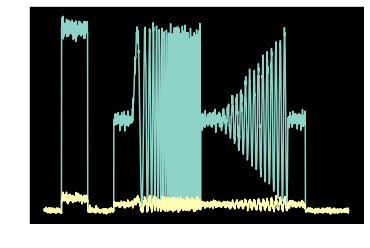

C:\Users\zfj\AppData\Local\Temp\ipykernel_27856\2924716969.py:10: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(enbleed, axis=(2)), aspect=60, interpolation='none')


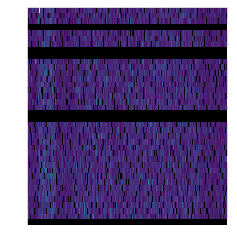

In [391]:
enbleed = ebleed.copy()
for i in range(len(enbleed)):
    enbleed[i] = enbleed[i] * nmask

plt.plot(np.nanmean(ebleed, axis=(0,2)))
plt.plot(np.nanmean(enbleed, axis=(0,2)))

plt.show()

plt.imshow(np.nanmean(enbleed, axis=(2)), aspect=60, interpolation='none')

1.0 1


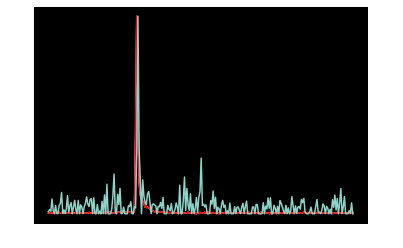

In [379]:
# fi = 1000
fi = 835

plt.plot(trace[int(c[fi])], 'w')
plt.plot(trace[pattern[fi]], 'r')

plt.twinx()
plt.plot(np.nanmean(ebleed[:,fi,:], axis=0))


print(c[fi],pattern[fi])

# c[fi]



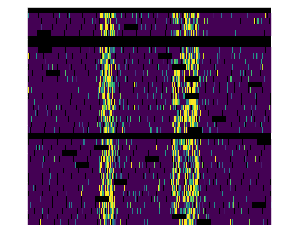

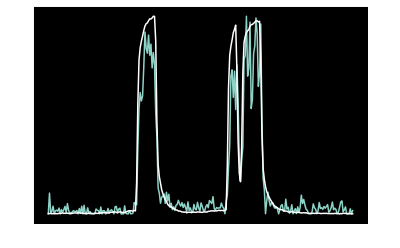

In [219]:
# pattern[1500], c[1500]
# c[1500]
fi = 1501

plt.imshow(ebleed[:,fi,:],aspect=6, interpolation='none')
plt.clim(0,100)
plt.show()
plt.plot(np.nanmean(ebleed[:,fi,:], axis=0))
plt.twinx()
# plt.plot(trace[pattern[fi]], 'w')
plt.plot(trace[int(c[fi])], 'w')



4.0

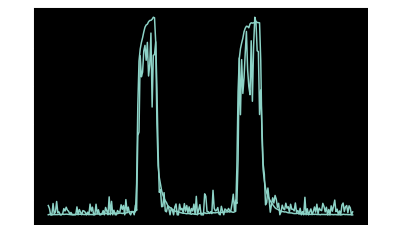

In [170]:
plt.plot(np.nanmean(ebleed[:,1500,:],axis = 0))
plt.twinx()
# plt.plot(lookup[pattern[1500]])
plt.plot(trace[int(c[1500])])
(c - pattern[:2098])[1500]

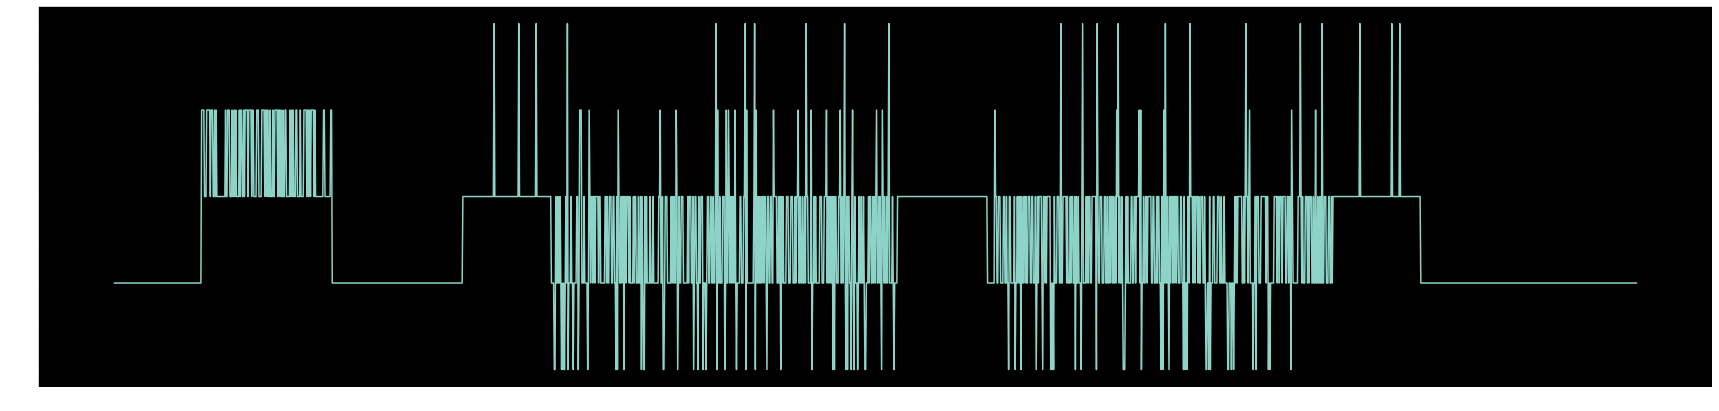

In [302]:
plt.figure(figsize=(30,7))
# plt.plot(np.nanmean(ebleed,axis = (0,2)))
c2 = c.copy()
c2[pattern[:2098]==0] = 0
plt.plot(c2 - pattern[:2098])

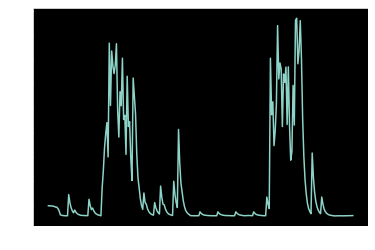

In [517]:
lookup = np.load('artifact_lut.npy')
lookup_n = lookup.astype(np.double) * 2 - 1
# lookup_n = lookup - lookup.mean(axis=1)
# lookup_n = lookup / lookup.std(axis=1)

best = np.empty((len(trials), 2098))
sim = np.empty(256)
tmp2 = np.empty(256)


tau = 2.066631039568971
kernel = np.flip(np.exp(-np.arange(10) / tau))

# # kernel = np.ones(15) / 15
# res = np.zeros_like(ebleed[0,120])
# for t in range(256):
#     start = max(0, t-10)
#     res[t] = np.nansum(ebleed[0,120,start:t] * kernel[:(t-start)])


plt.plot(res)

for trial in range(len(trials)):
    for frame in range(2098):
        tmp = ebleed[trial, frame].copy() # 256 wide
        # tmp -= np.nanmin(tmp)
        # tmp /= np.nanmax(tmp)
        # tmp = tmp*2 - 1
        for t in range(256):       
            start = max(0, t-10)
            tmp2[t] = np.nansum(tmp[start:t] * kernel[:(t-start)])

        for i in range(256):
            sim[i] = np.nansum(tmp2 * lookup_n[i])
        best[trial,frame] = np.argmax(sim)
    # tn = ebleed[trial] - np.nanmean(ebleed[trial], axis=1, keepdims=True)
    # tss = np.nansum(tn**2, axis=1, keepdims=True)

    # # cdot = tn * lookup_n
    # for frame in range(256):
    #     cdot[:,frame,:] = tn[:,frame, None] * lookup_n[frame,None,:]

    # corr = np.nansum(cdot, axis=1) / np.sqrt(np.dot(tss, lookup_s)) 
    # # this will be 2098 X 256
    # best[trial] = np.argmax(corr, axis=1)
    # #this will be 2098 x 1

    # # for frame in range(2098):
    # #     np.corrcoef()


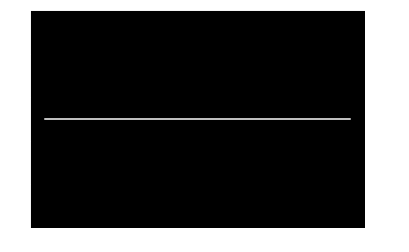

In [538]:
# plt.plot(best.T)
# plt.plot(best[-1])
# # print(tn.shape, tss.shape, corr.shape)
# # plt.imshow(corr, aspect=1/10, interpolation='none')
# # plt.imshow(np.dot(tn, lookup_n), aspect=1/10, interpolation='none')
# # plt.plot(tn)
# # plt.plot(tss)
# # ebleed[0,0]

# plt.show()

# # best.shape
# # lookup.shape, ebleed.shape
# plt.plot(ebleed[trial, frame])
# plt.plot(ebleed[trial, frame].copy())
# plt.imshow(ebleed[0],interpolation='none', aspect=1/6)
# plt.plot(np.nansum(ebleed[0], axis=1))    
# lookup_n = lookup.astype(np.double) * 2 - 1
lookup = np.load('artifact_lut.npy')

lookup_n = ~lookup
tmp = ebleed[trial, frame].copy()
tmp2 = np.empty_like(tmp)
for t in range(256):       
    start = max(0, t-10)
    tmp2[t] = np.nansum(tmp[start:t] * kernel[:(t-start)])

# plt.plot(tmp2)

for i in range(256):
    sim[i] = np.nansum(tmp2 * lookup_n[i])
np.argmax(sim)

plt.twinx()
plt.plot(lookup_n[np.argmax(sim)], 'w')
# plt.imshow(~lookup_n)

# tau = 2.066631039568971
# # tau = 
# kernel = np.flip(np.exp(-np.arange(10) / tau))

# # kernel = np.ones(15) / 15
# res = np.zeros_like(ebleed[0,120])
# for t in range(256):
#     start = max(0, t-10)
#     res[t] = np.nansum(ebleed[0,120,start:t] * kernel[:(t-start)])


# plt.plot(res)


In [63]:
xa = np.zeros((256,256))

for intensity in range(256):

    x2 = np.zeros_like(xss[1])
    for k in range(8):
        if intensity & 2**k:
            # print(2**k)
            x2 += (xss[2**k] - np.percentile(xss[2**k], 2))/np.percentile(xss[2**k],98)

    # x2 -= x2[:64].mean()
    # x2 /= x2[:64].std()

    xa[intensity,:] = np.sort(x2)

In [68]:
xss[1].shape

(256,)

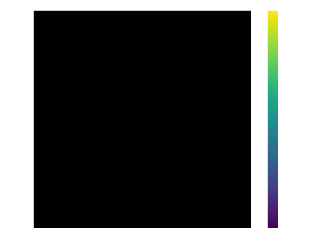

In [64]:
plt.imshow(xa)
# plt.plot(xa.T)
plt.clim(0,2)
plt.colorbar()
plt.show()

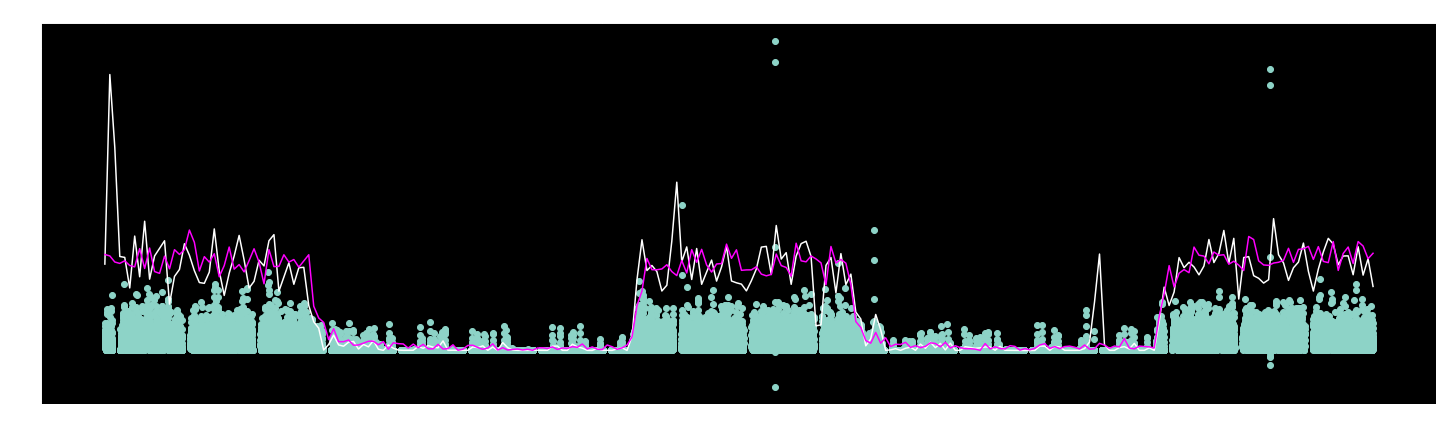

In [42]:
plt.figure(figsize=(25,7))
ax = plt.gca()
# plt.plot(np.arange(256),xss[128][-2,:])
i = 500
ax.scatter(
tt[props['flips'][i] : props['flips'][i+1]],
      func[props['flips'][i] : props['flips'][i+1]] / 10,
)
ax2 = ax.twiny()
ax2.plot(
      np.arange(256),
      interp1d(
            tt[props['flips'][i] : props['flips'][i+1]],
            func[props['flips'][i] : props['flips'][i+1]],
            )(np.linspace(
            tt[props['flips'][i]], 
            tt[props['flips'][i+1]-1], 
            256 * navgs # average time points within the bins to improve SNR
            )).reshape(256,navgs).mean(axis=1),
      'w'
)

from scipy.interpolate import RBFInterpolator
spline = lambda x,y: RBFInterpolator(x[:,None],y[:,None], neighbors=100, smoothing = 10.0, kernel='multiquadric', epsilon=1.0)

ax2.plot(
      np.arange(256),
      spline(
            np.concatenate([
                  tt[props['flips'][i] : props['flips'][i+1]] - tt[props['flips'][i]]
            for i in range(len(props['flips']) - 2)]),
            func[props['flips'][0] : props['flips'][-2]],
            )(
                  np.linspace(
            0,1/60.0, 
            256
            )[:,None]
      ), 'magenta'
      )


plt.show()

In [8]:
props = preprocess.process_raw_file(os.path.join(dir, "502_1636k_00001.tif"), None)

AttributeError: module 'util.preprocess' has no attribute 'process_raw_file'

In [5]:
events = pd.DataFrame({'pre_on':props['flips'][0], 'stim_on':props['flips'][0], 'tail_off':props['flips'][-1]}, index=[0])
events

,pre_on,stim_on,tail_off
0,13157891,13157891,122814463


In [7]:
tif = suite2p.io.tiff.ScanImageTiffReader(os.path.join(dir, "502_1636k_00001.tif"))
data = tif.data().reshape(-1,props['n_channels'],*props['frame_shape']).astype(np.int16)

#get the approximate time of each pixel
F,C,Y,X = data.shape
tt = np.zeros((F,Y,X))
tt += np.arange(0, X)[None, None, :] / props['pixel_rate']
tt += np.arange(0, Y)[None, :, None] / props['line_rate']
tt += ((props['time_stamps'] - props['time_stamps'][0]) / 1e7)[:, None, None]
tt = tt.flatten()

func = data[:,1,:,:].copy()
func[:,1::2,:] = np.flip(func[:,1::2,:], axis=2) #bidi scanning
func = func.flatten()

NameError: name 'props' is not defined

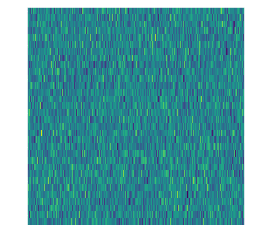

In [47]:
plt.imshow(data[:,1,:,:].mean(axis=0), aspect=64,interpolation='None')

In [107]:
from scipy.interpolate import UnivariateSpline
spline = lambda x: UnivariateSpline(x['t'].to_numpy(),x['y'].to_numpy(), s = 100)
xn = np.linspace(0.0,1/60,300)

df = pd.DataFrame({
    't':np.concatenate([
        tt[props['flips'][i] : props['flips'][i+1]] - tt[props['flips'][i]] 
        for i in range(1,10)#range(len(props['flips']) - 2)
        ]),
    'y':func[props['flips'][1] : props['flips'][10]].astype(np.float64),})

# df.sort_values('t', inplace=True)
print(np.all(df['t'].to_numpy()[:-1] <= df['t'].to_numpy()[1:]))
spl = spline(df.groupby('t').mean().reset_index())
s = spl(xn)

True


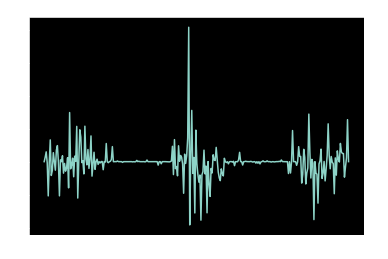

In [109]:
# s
spl.set_smoothing_factor(1.0)
plt.plot(xn,spl(xn))
# df['t']
# plt.scatter(df['t'],df['y'])
# df['t']

# df.groupby('t').mean().reset_index()['t']

In [114]:
df = preprocess.segment(data[:,1,:,:], props, events, np.ones(props['frame_shape']), os.path.join(dir,"dark_level_00002.tif"))[0]

In [124]:
df['tm'] = df['trial_t'] % 1.0/60
df.sort_values('tm', inplace=True)

In [60]:
from scipy.interpolate import RBFInterpolator
spline = lambda x: RBFInterpolator(x['tm'].to_numpy()[:,None],x['fluor'].to_numpy()[:,None],neighbors=200, smoothing = 0, degree = 100)
xn = np.linspace(0.0,1/60,300)[:,None]
s = spline(df[::1000])(xn)

TypeError: <lambda>() takes 1 positional argument but 2 were given

In [52]:
import GPy
# print(rois[0]['trial_t'][:,None].shape, rois[0]['dFoF'][:,None].shape)
# m1 = GPy.models.SparseGPRegression(
#     np.concatenate([
#         tt[props['flips'][i] : props['flips'][i+1]] - tt[props['flips'][i]] 
#         for i in range(50)#range(len(props['flips']) - 2)
#         ])[:,None],
#     func[props['flips'][0] : props['flips'][50]][:,None],
#     num_inducing=30,
#     kernel = GPy.kern.RBF(1),
# )

# m1.rbf.lengthscale.constrain_bounded(1e-4,1e-1)

# m1.optimize_restarts(4, messages=False, max_iters = 20)

# mu1,std1 = m1.predict(xn, include_likelihood = False)
# _,std2 = m1.predict(xn, include_likelihood = True)

import climin

xn = np.linspace(0.0,1/60,300)[:,None]

rbf = GPy.kern.RBF(1)
rbf.lengthscale.constrain_bounded(1/(60*5),1/(60*2))
m1 = GPy.core.SVGP(
    np.concatenate([
        tt[props['flips'][i] : props['flips'][i+1]] - tt[props['flips'][i]] 
        for i in range(1,1000)#range(len(props['flips']) - 2)
        ])[:,None],
    func[props['flips'][1] : props['flips'][1000]][:,None],
    np.linspace(0,1/60,300)[:,None],
    rbf,
    GPy.likelihoods.Gaussian(),
    batchsize=500
)

reconstraining parameters rbf.lengthscale


In [58]:
opt = climin.Adadelta(m1.optimizer_array, m1.stochastic_grad, step_rate=0.2, momentum=0.9)

from ipywidgets import IntProgress
from IPython.display import display

f = IntProgress(min=1, max=5000) # instantiate the bar
display(f)

def callback(i):
    #Stop after 5000 iterations
    f.value += 1
    if i['n_iter'] > 5000:
        return True
    return False
info = opt.minimize_until(callback)


IntProgress(value=1, max=5000, min=1)

  rbf.         |  value  |                 constraints                  |  priors
  variance     |    nan  |                     +ve                      |        
  lengthscale  |    nan  |  0.0033333333333333335,0.008333333333333333  |        


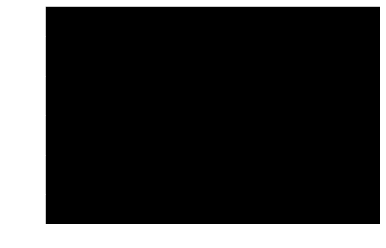

In [59]:
mu1,std1 = m1.predict(xn, include_likelihood = False)
_,std2 = m1.predict(xn, include_likelihood = True)

plt.plot(xn, mu1)  
print(rbf) 

In [157]:
md = tif.metadata()

In [159]:
props['frame_index']

array([-1.000e+00, -1.000e+00, -1.000e+00, ...,  1.895e+03,  1.895e+03,
        1.895e+03])

In [49]:
dir = "C:\\Users\\zfj\\data\\021423B_testing"
f = "aliasing_00001.tif"
navgs=10

In [50]:
#load the data
props = preprocess.process_raw_file(os.path.join(dir, f), None)
tif = suite2p.io.tiff.ScanImageTiffReader(os.path.join(dir, f))
data = tif.data().reshape(-1,props['n_channels'],*props['frame_shape']).astype(np.int16)     

#get the approximate time of each pixel
F,C,Y,X = data.shape
tt = np.zeros((F,Y,X))
tt += np.arange(0, X)[None, None, :] / props['pixel_rate']
tt += np.arange(0, Y)[None, :, None] / props['line_rate']
tt += ((props['time_stamps'] - props['time_stamps'][0]) / 1e7)[:, None, None]
tt = tt.flatten()

func = data[:,1,:,:].copy()
func[:,1::2,:] = np.flip(func[:,1::2,:], axis=2) #bidi scanning
func = func.flatten()
#NOTE: we're flipping the data channel so that the time is strictly increasing

xs = np.empty((len(props['flips']) - 1,256)) * np.nan
xb = np.empty((len(props['flips']) - 1,256)) * np.nan
i = 0

while i < len(props['flips']) - 1: # iterate through each frame
  if props['flips'][i] in props['dropped']:
    print('.', end='')
    i+=1
    continue

  #TODO: filter out frames where the flip occurs on a line barrier?
  if not props['flips'][i] % props['frame_shape'][1]:
    print('!', end='')

  #TODO: these are wrong...
  if props['frame_index'][props['flips'][i] +1] > 187:
    i+=1
    continue
  if props['frame_index'][props['flips'][i] +1] < 60:
    #resample the data into 256 temporal bins of equal spacing
    xb[i,:] = interp1d(
      tt[props['flips'][i] : props['flips'][i+1]],
      func[props['flips'][i] : props['flips'][i+1]],
      )(np.linspace(
          tt[props['flips'][i]], 
          tt[props['flips'][i+1]-1], 
          256 * navgs # average time points within the bins to improve SNR
          )).reshape(256,navgs).mean(axis=1)    
  else:
    #resample the data into 256 temporal bins of equal spacing
    xs[i,:] = interp1d(
      tt[props['flips'][i] : props['flips'][i+1]],
      func[props['flips'][i] : props['flips'][i+1]],
      )(np.linspace(
          tt[props['flips'][i]], 
          tt[props['flips'][i+1]-1], 
          256 * navgs # average time points within the bins to improve SNR
          )).reshape(256,navgs).mean(axis=1)
  i += 1

Dropped 7199 frames in 106 trials (42.699%)
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!....................................................................................................................................................................................................................................................

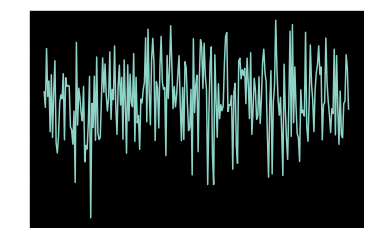

In [51]:
# plt.plot(np.nanmean(xs,axis=0))
# plt.plot(np.nanmean(xb,axis=0))
plt.plot(np.nanmean(xs,axis=0) - np.nanmean(xb,axis=0))

In [22]:
trig = data[:,-1,:,:].copy()
trig[:,1::2,:] = np.flip(trig[:,1::2,:], axis=2)

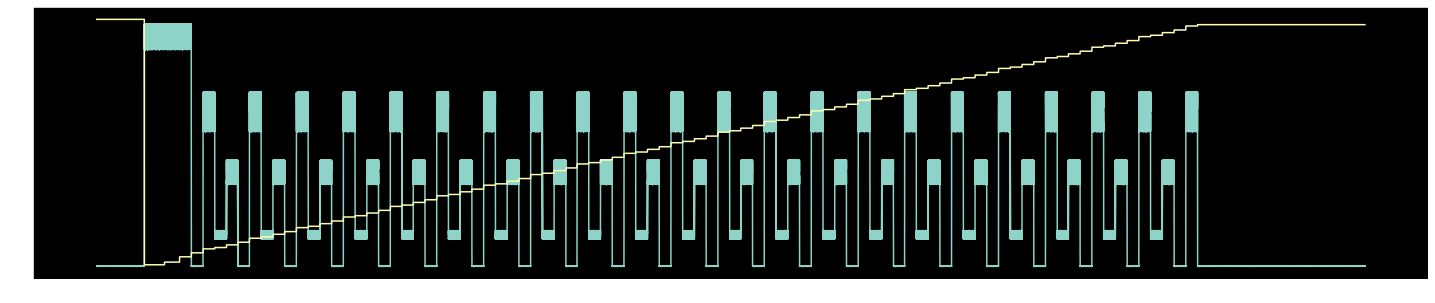

In [28]:
plt.figure(figsize=(25,5))
plt.plot(trig.flat[12200000:12700000]/20000 * 180)
plt.plot(props['frame_index'][12200000:12700000])


In [56]:
props['frame_index'][props['flips'][:100] -1]

array([ -1,   1,   5,   9,  13,  16,  19,  20,  22,  24,  27,  28,  30,
        32,  35,  36,  38,  40,  43,  44,  46,  48,  51,  52,  54,  56,
        59,  60,  62,  64,  67,  68,  70,  72,  75,  76,  78,  80,  83,
        84,  86,  88,  91,  92,  94,  96,  99, 100, 102, 104, 107, 108,
       110, 112, 115, 116, 118, 120, 123, 124, 126, 128, 131, 132, 134,
       136, 139, 140, 142, 144, 147, 148, 150, 152, 155, 156, 158, 160,
       163, 164, 166, 168, 171, 172, 174, 176, 179, 180, 182, 184, 187,
       188,   3,   5,   9,  12,  15,  16,  18,  20])